In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
from loadmodules import *
import scipy as sp
from numba import jit

In [2]:
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4' in directory]
print(simulation_list)

['Au6_lvl4_aa96_fixcs', 'Au6_lvl4_aa96_tightconstrain']


# ICMF sampling test

In [3]:
# sf = load_subfind(127, dir=path+simulation_list[0]+'/output/')
# s_clusterpdir = gadget_readsnap(127, snappath=path+simulation_list[0]+'/output/', subfind=sf, loadonlytype=[4], loadonlyhalo=0, applytransformationfacs=True)
# s_clusterpdir.calc_sf_indizes(sf)
# rot_matrix = s_clusterpdir.select_halo(sf)

sf = load_subfind(127, dir=path+simulation_list[1]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(127, snappath=path+simulation_list[1]+'/output/', subfind=sf, hdf5=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.1 * sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

/storage/home/can35/can35007/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.13369912,  0.30828502,  0.94185184],
       [ 0.80876937, -0.51530016,  0.28347461],
       [ 0.57272738,  0.79964123, -0.18043631]])

In [4]:
solar_mass_g = 1.989e33
Gcosmo = 43.

In [5]:
starparts = s.data['type']==4
imclus = s.data['imcl'][s.data['incl']>0].flatten()*s.UnitMass_in_g/solar_mass_g
imtotclus = s.data['imfc'][s.data['incl']>0]*s.data['mass'][starparts][s.data['incl']>0]*s.UnitMass_in_g/solar_mass_g
inclus = s.data['incl'][s.data['incl']>0].flatten()
mtrunc = s.data['mtrc'][s.data['incl']>0] * s.UnitMass_in_g/solar_mass_g

In [6]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True)

/storage/home/can35/can35007/pylib/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


In [7]:
def ICMF(norm, m, mtrunc):
    return norm*np.exp(-m/mtrunc)/m**2

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [8]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(imclus[imclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [9]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)

In [10]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

In [11]:
%matplotlib inline

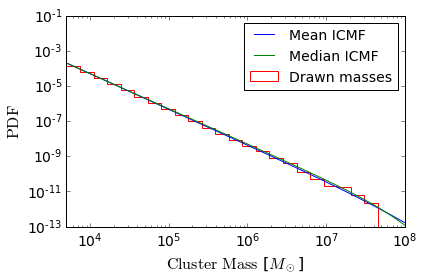

In [12]:
plt.loglog(marray_gcmf, np.mean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.median(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(imtotclus/inclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(imclus[imclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test_consistent.pdf')

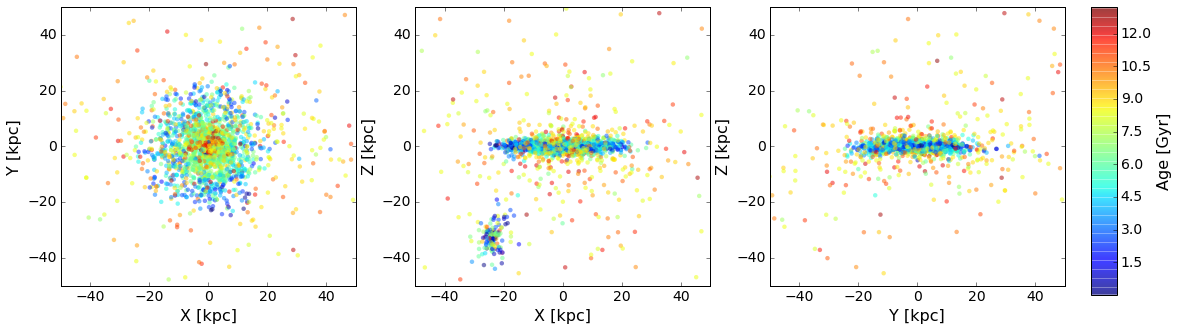

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], c=stars_age[s.data['nclt']>0], alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

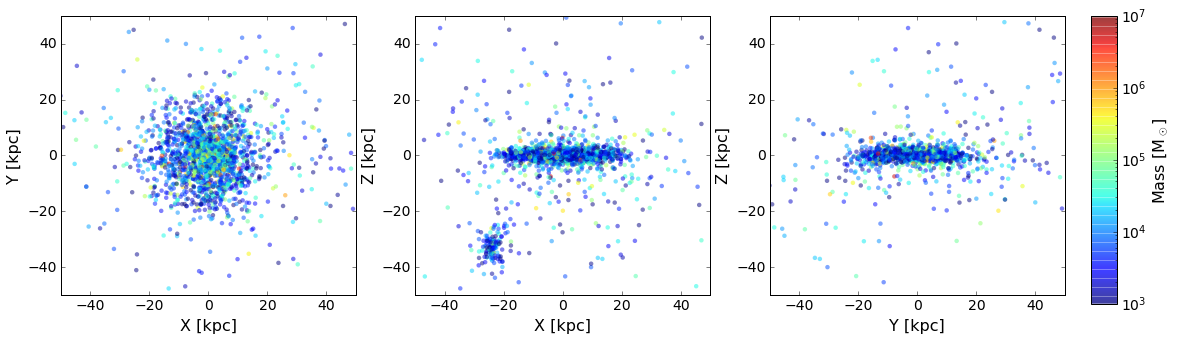

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-50,50)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,2], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-50,50)
ax[1].set_ylim(-50,50)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][starparts][s.data['nclt']>0][:,1], 1e3*s.data['pos'][starparts][s.data['nclt']>0][:,0], 
              c=(1e10*s.data['mass'][starparts]*s.data['mfcl'])[s.data['nclt']>0], norm=colors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-50,50)
ax[2].set_ylim(-50,50)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_mass_distribution.pdf')

In [15]:
mclus = s.data['mclt'][s.data['nclt']>0].flatten()
mclus = mclus[mclus>0]
nclus = s.data['nclt'][s.data['nclt']>0]

In [16]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)
# print(kinetic_energy)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5
# print(orbital_energy.min(),orbital_energy.max())
e_max = orbital_energy.max()
orbital_energy -= e_max
# print(orbital_energy.min(),orbital_energy.max())
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
Lz *= np.sign(np.nanmedian(Lz))

parts_radius = s.r()
isort_parts = np.argsort(parts_radius)
revert_sort = np.argsort(isort_parts)
cummass = np.cumsum(s.data['mass'][isort_parts])
Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
Ecirc /= 1e5
Ecirc -= e_max

/apps/PYTHON/3.7.4-Anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [17]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

# Example usage
mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

In [22]:
r_test = np.linspace(parts_radius.min(), parts_radius.max(),10000)
Ecirc_f = sp.interpolate.interp1d(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')
Vc_f = sp.interpolate.interp1d(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')
Mr_f = sp.interpolate.interp1d(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask], bounds_error=False, fill_value='extrapolate')

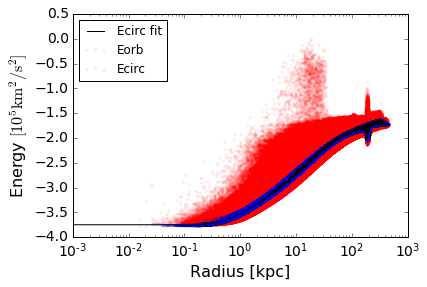

In [23]:
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], orbital_energy[isort_parts][~np.isinf(Ecirc)][mask], c='r', edgecolors='face', label='Eorb', s=5, alpha=0.05)
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], edgecolors='face', label='Ecirc', s=5, alpha=0.05)
plt.plot(1e3*r_test, Ecirc_f(r_test), c='k', label='Ecirc fit')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Energy $[10^5 \rm{km}^2/\rm{s}^2]$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

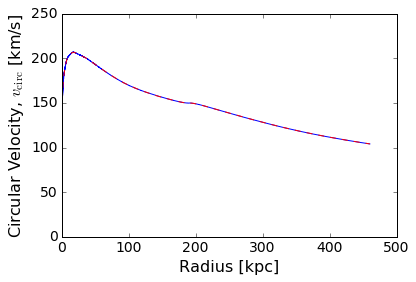

In [24]:
plt.plot(1e3*parts_radius[isort_parts], Vc_parts[isort_parts])
plt.plot(1e3*r_test, Vc_f(r_test), 'r--')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Circular Velocity, $v_{\rm{circ}}$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14)

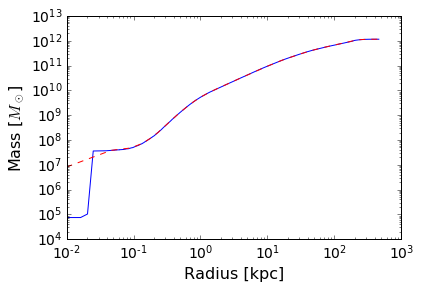

In [25]:
plt.plot(1e3*parts_radius[isort_parts], 1e10*cummass)
plt.plot(1e3*r_test, 1e10*Mr_f(r_test), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Mass [$M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [28]:
@jit(nopython=True, parallel=True)
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    velocity_dispersion = np.std(velocities)
    return velocity_dispersion

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

In [29]:
idx = np.argmin(np.abs(orbital_energy[starparts][s.data['nclt']>0][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_clus = r_test[idx]
vc_rc_clus = Vc_f(rc_clus)
M_rc_clus = Mr_f(rc_clus)
sigma_rc_clus = np.array([velocity_dispersion(rc, parts_radius, starparts, s.data['age'], s.data['vel'], s.data['type']) for rc in rc_clus])

rc_clus = np.repeat(rc_clus, nclus)
M_rc_clus = np.repeat(M_rc_clus, nclus)
vc_rc_clus = np.repeat(vc_rc_clus, nclus)
sigma_rc_clus = np.repeat(sigma_rc_clus, nclus)

In [30]:
r_clus = np.repeat(parts_radius[starparts][s.data['nclt']>0],nclus)
vc_clus = np.repeat(Vc_parts[starparts][s.data['nclt']>0],nclus)

(0, 500)

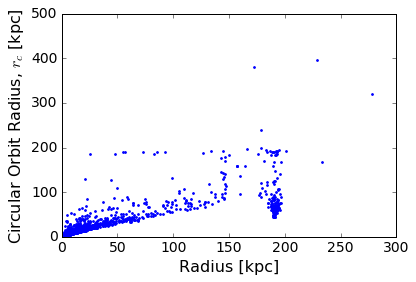

In [31]:
plt.scatter(1e3*r_clus,1e3*rc_clus, s=3, edgecolors='face')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.xlim(0,300)
plt.ylim(0,500)

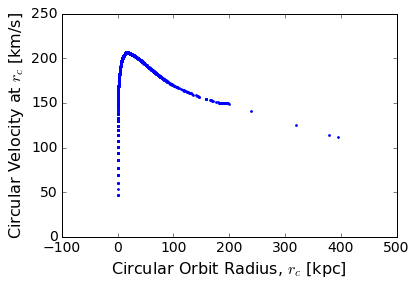

In [32]:
plt.scatter(1e3*rc_clus,vc_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Circular Velocity at $r_c$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

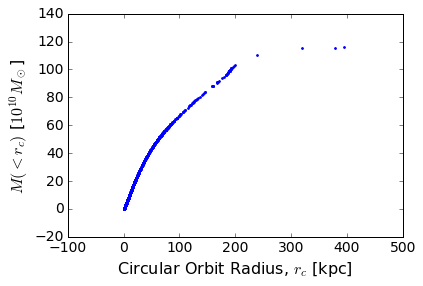

In [33]:
plt.scatter(1e3*rc_clus,M_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel(r'$M(<r_c)$ [$10^{10} M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

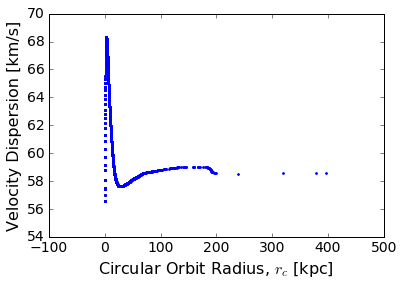

In [34]:
plt.scatter(1e3*rc_clus,sigma_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Velocity Dispersion [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [35]:
J_mod = np.sqrt((np.cross(s.data['pos'], s.data['vel'])**2).sum(axis=1))
Jc_clus = rc_clus*vc_clus
circ_param_clus0 = np.repeat(Lz[starparts],s.data['nclt'])/Jc_clus
circ_param_clus1 = (np.repeat(J_mod[starparts],s.data['nclt'])/Jc_clus)

In [36]:
circ_param_clus0.min(),circ_param_clus0.max(), circ_param_clus1.min(), circ_param_clus1.max()

(-1.0152875199161369,
 3.3849813158533975,
 0.007271307945657387,
 3.593021774872279)

In [37]:
# feps = np.repeat(np.abs(circ_param[starparts][s.data['nclt']>0])**0.78, nclus)
feps = (circ_param_clus1)**0.78
coulumblog = np.log(1. + M_rc_clus/mclus)

In [38]:
tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)
np.nanmin(tdf), np.nanmax(tdf)
clus_age = np.repeat(stars_age[s.data['nclt']>0],nclus)
mask_disrupted = (tdf<clus_age)
mask_disrupted.sum()

69

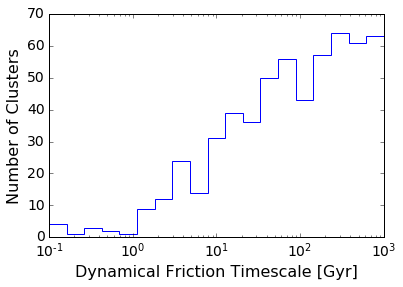

In [39]:
plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
plt.xscale('log')
plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
plt.ylabel('Number of Clusters', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

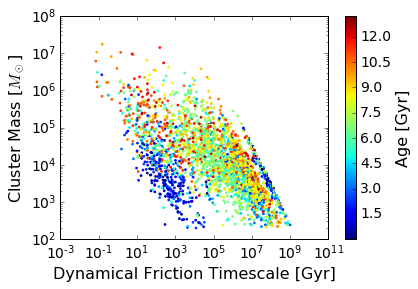

In [40]:
cb = plt.scatter(tdf, 1e10*mclus, s=3, c=clus_age, edgecolors='face')
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
plt.ylabel('Cluster Mass [$M_\odot$]', fontsize=16)
xticks = plt.xticks()[0]
plt.xticks(xticks[::2])
plt.tick_params(axis='both', which='both', labelsize=14)

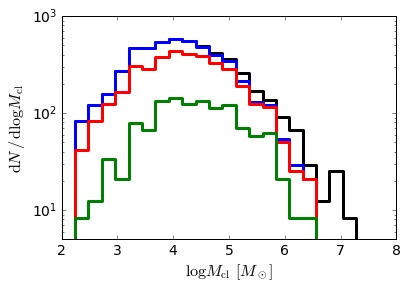

In [41]:
nbins = 25
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

N,_ = np.histogram(np.log10(1e10*mclus[(circ_param_clus0<0.8)]), bins=marray_gcmf)
all_clusters = N/width
N,_ = np.histogram(np.log10(1e10*mclus[~mask_disrupted * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[~mask_disrupted * (clus_age>6.) * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[~mask_disrupted *(clus_age>10.) * (circ_param_clus0<0.8)]), bins=marray_gcmf)
after_df_old = N/width

plt.step(marray_gcmf[:-1], all_clusters, where='post',c='k', linewidth = 3)
plt.step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3)
plt.step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3)
plt.step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3)
plt.yscale('log')
plt.ylim(5e0, 1e3)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  4.,  3.,
        11., 12.,  5., 10., 11.,  2.,  2.,  5.,  1.,  0.,  0.,  0.]),
 array([2.  , 2.24, 2.48, 2.72, 2.96, 3.2 , 3.44, 3.68, 3.92, 4.16, 4.4 ,
        4.64, 4.88, 5.12, 5.36, 5.6 , 5.84, 6.08, 6.32, 6.56, 6.8 , 7.04,
        7.28, 7.52, 7.76, 8.  ]),
 <a list of 1 Patch objects>)

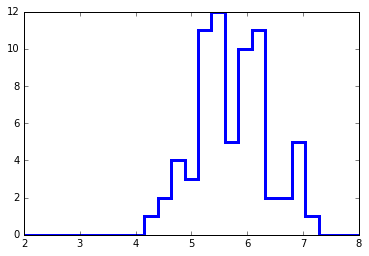

In [42]:
plt.hist(np.log10(1e10*mclus[mask_disrupted]), bins=marray_gcmf, histtype='step', label='All Clusters', linewidth=3)

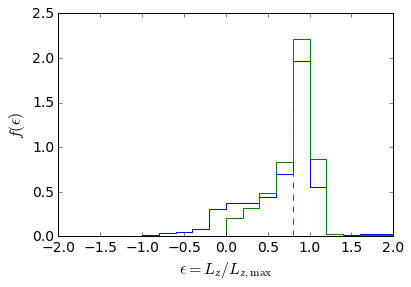

In [43]:
# plt.hist(circ_param[starparts][s.data['age']>0], histtype='step', density=True, bins=20, range=[-2.,2.])
plt.hist(circ_param_clus0, bins=20, range=[-2.,2.], histtype='step', density=True)
plt.hist(circ_param_clus1, bins=20, range=[-2.,2.], histtype='step', density=True)
plt.vlines(0.8,0,1.4, color='r', linestyles='dashed')
plt.xlabel(r'$\epsilon = L_z / L_{z,\rm{max}}$', fontsize=16)
plt.ylabel(r'$f(\epsilon)$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

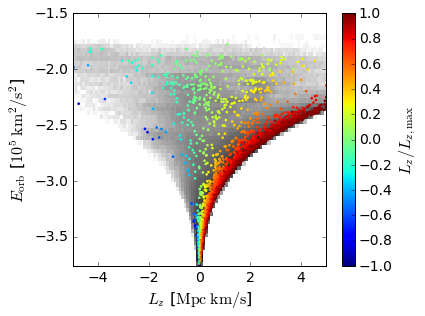

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[starparts][s.data['age']>0.], orbital_energy[starparts][s.data['age']>0.], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['age']>0.].min(), 0.]), rasterized=True, cmap='Greys', norm=colors.LogNorm() )
cb = ax.scatter( np.repeat(Lz[starparts],s.data['nclt']), np.repeat(orbital_energy[starparts],s.data['nclt']), c=circ_param_clus0, vmin=-1, vmax=1, s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['age']>0.].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

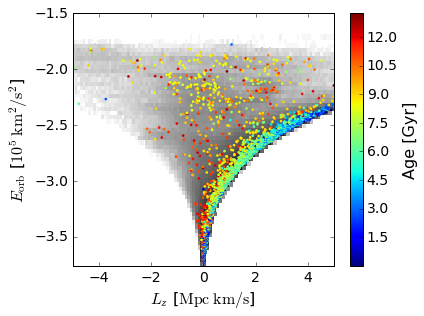

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[starparts][s.data['age']>0.], orbital_energy[starparts][s.data['age']>0.], bins=(100, 100), range=([-5, 5], [orbital_energy[starparts][s.data['age']>0.].min(), 0.]), rasterized=True, cmap='Greys', norm=colors.LogNorm() )
cb = ax.scatter( Lz[starparts][s.data['nclt']>0], orbital_energy[starparts][s.data['nclt']>0], c=stars_age[s.data['nclt']>0], s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[starparts][s.data['age']>0.].min(), -1.5)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)